In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pystan
import arviz

In [2]:
def read_data():
    file = '../data/chapter02/Blood.csv'
    df = pd.read_csv(file)
    
    return df

In [3]:
df = read_data()

In [4]:
df.head()

,Bld_types,Bld_code,NS,HA,RD,P,SD,C,ST
0,O,1,8,31,13,3,21,22,3.0
1,O,1,8,22,20,8,29,34,16.0
2,O,1,9,29,13,5,17,31,5.0
3,O,1,10,16,12,3,36,32,3.0
4,O,1,10,31,14,6,30,24,3.0


In [5]:
df.describe()

,Bld_code,NS,HA,RD,P,SD,C,ST
count,1427.000000,1427.000000,1427.000000,1427.000000,1427.000000,1427.000000,1427.000000,1426.000000
mean,2.249474,21.941836,18.819902,14.983181,4.421864,28.119131,28.100911,9.424965
std,0.985586,5.148848,6.246610,3.178822,1.849157,6.570886,5.365169,4.757448
min,1.000000,5.000000,0.000000,3.000000,0.000000,3.000000,7.000000,0.000000
25%,1.000000,18.000000,15.000000,13.000000,3.000000,24.000000,24.000000,6.000000
50%,2.000000,22.000000,19.000000,15.000000,4.000000,29.000000,28.000000,9.000000
75%,3.000000,25.500000,23.000000,17.000000,6.000000,33.000000,32.000000,12.000000
max,4.000000,38.000000,34.000000,22.000000,8.000000,42.000000,44.000000,29.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1427 entries, 0 to 1426
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Bld_types  1427 non-null   object 
 1   Bld_code   1427 non-null   int64  
 2   NS         1427 non-null   int64  
 3   HA         1427 non-null   int64  
 4   RD         1427 non-null   int64  
 5   P          1427 non-null   int64  
 6   SD         1427 non-null   int64  
 7   C          1427 non-null   int64  
 8   ST         1426 non-null   float64
dtypes: float64(1), int64(7), object(1)
memory usage: 100.5+ KB


In [7]:
model = '''
    data { 
        int<lower=0> n;                              //データ数 
        int<lower=0> a;                              //A水準数   
        vector[n]    y;                              //特性値   
        int<lower=0> A[n];                           //A水準   
        real mL; real mH; real sL; real sH;             //事前分布
    }
    parameters {
        vector<lower=mL,upper=mH>[a] muA;            //A平均
        real<lower=sL,upper=sH>   sigmaE;            //誤差SD
    }
    model {
        for(i in 1:n){y[i]~normal(muA[A[i]],sigmaE);}//正規分布
    }
    generated quantities{
        real<lower=sL,upper=sH>  sigmaA;             //要因ASD
        real<lower=0,upper=1>      eta2;             //説明率
        real                         mu;             //全平均
        vector                   [a] aj;             //A効果
        sigmaA  = sqrt(variance(muA)*(a-1)/a);       
        eta2  = pow(sigmaA,2)/(pow(sigmaA,2)+pow(sigmaE,2));
        mu  = mean(muA);
        for (i in 1:a){aj[i]  = muA[i]-mu;}
    }
'''

In [10]:
%%time
stm = pystan.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_94f0b8e4efc8a07603e3c167ad5a2add NOW.
C:\Users\User\anaconda3\lib\site-packages\Cython\Compiler\Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\User\AppData\Local\Temp\tmp0fxet2d0\stanfit4anon_model_94f0b8e4efc8a07603e3c167ad5a2add_2382378923947034838.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


Wall time: 52 s


In [17]:
def execute_fit(stm, df, item):
    data = {'n':len(df) , 'a':4, 'y':df[item], 'A':df['Bld_code'], 'mL':0, 'mH':100, 'sL':0, 'sH':100}
    n_itr = 1500
    n_warmup = 500
    chains = 4

    # サンプリングの実行
    fit = stm.sampling(data=data, iter=n_itr, chains=chains, n_jobs=1, warmup=n_warmup, algorithm='NUTS', verbose=True)
    
    return fit

In [18]:
df.columns

Index(['Bld_types', 'Bld_code', 'NS', 'HA', 'RD', 'P', 'SD', 'C', 'ST'], dtype='object')

In [29]:
fit_2 = execute_fit(stm, df, 'SD')

In [32]:
%%time
#items = ['NS', 'HA', 'RD', 'P', 'SD', 'C', 'ST']
items = ['NS', 'HA', 'RD', 'P', 'SD']
fit_result = {}

for item in items:
    fit_result[item] = execute_fit(stm, df, item)

Wall time: 26.7 s


In [13]:
fit

Inference for Stan model: anon_model_94f0b8e4efc8a07603e3c167ad5a2add.
2 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=1000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
muA[1]   4.33  2.5e-3   0.09   4.16   4.28   4.34   4.39   4.51   1178    1.0
muA[2]   4.27  3.0e-3    0.1   4.06   4.21   4.27   4.33   4.47   1113    1.0
muA[3]   4.59  2.3e-3   0.08   4.42   4.53   4.59   4.64   4.76   1265    1.0
muA[4]   4.44  4.9e-3   0.16   4.14   4.31   4.43   4.55   4.76   1131    1.0
sigmaE   1.85  1.0e-3   0.03   1.78   1.82   1.85   1.87   1.92   1091    1.0
sigmaA   0.15  1.6e-3   0.05   0.06   0.12   0.15   0.18   0.25    801    1.0
eta2   7.1e-3  1.5e-4 4.2e-3 1.2e-3 4.1e-3 6.3e-3 9.3e-3   0.02    772    1.0
mu       4.41  1.6e-3   0.06    4.3   4.37   4.41   4.44   4.51   1136    1.0
aj[1]   -0.07  2.4e-3   0.08  -0.22  -0.13  -0.07  -0.02   0.08   1142    1.0
aj[2]   -0.14  3.0e-3    0.1  -0.

In [22]:
fit

Inference for Stan model: anon_model_94f0b8e4efc8a07603e3c167ad5a2add.
5 chains, each with iter=11000; warmup=1000; thin=1; 
post-warmup draws per chain=10000, total post-warmup draws=50000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
muA[1]   4.33  3.7e-4   0.09   4.16   4.27   4.33   4.39   4.51  58642    1.0
muA[2]   4.26  4.4e-4    0.1   4.06   4.19   4.26   4.33   4.46  53785    1.0
muA[3]   4.59  3.3e-4   0.08   4.43   4.53   4.59   4.64   4.75  58468    1.0
muA[4]   4.44  7.0e-4   0.16   4.12   4.32   4.44   4.55   4.76  54985    1.0
sigmaE   1.85  1.4e-4   0.03   1.78   1.82   1.85   1.87   1.92  58082    1.0
sigmaA   0.15  2.2e-4   0.04   0.07   0.12   0.15   0.18   0.24  39999    1.0
eta2   7.2e-3  2.1e-5 4.1e-3 1.3e-3 4.2e-3 6.5e-3 9.4e-3   0.02  37569    1.0
mu       4.41  2.4e-4   0.06    4.3   4.37    4.4   4.44   4.52  55100    1.0
aj[1]   -0.07  3.6e-4   0.09  -0.24  -0.13  -0.07  -0.01   0.09  57221    1.0
aj[2]   -0.14  3.9e-4   0.09

In [24]:
fit_2

Inference for Stan model: anon_model_94f0b8e4efc8a07603e3c167ad5a2add.
4 chains, each with iter=1500; warmup=500; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
muA[1]  22.09  4.0e-3   0.25   21.6  21.93  22.09  22.26  22.58   3910    1.0
muA[2]  22.05  4.0e-3   0.28   21.5  21.86  22.05  22.24  22.61   5098    1.0
muA[3]  21.88  3.1e-3   0.22  21.45  21.73  21.88  22.03  22.32   5019    1.0
muA[4]  21.39  6.6e-3   0.45   20.5  21.09  21.38  21.69   22.3   4737    1.0
sigmaE   5.15  1.4e-3   0.09   4.97   5.09   5.15   5.21   5.34   4521    1.0
sigmaA   0.36  2.5e-3   0.16   0.09   0.24   0.34   0.46   0.71   4109    1.0
eta2   5.7e-3  7.9e-5 4.9e-3 3.2e-4 2.1e-3 4.3e-3 8.0e-3   0.02   3804    1.0
mu      21.85  2.2e-3   0.16  21.55  21.75  21.85  21.96  22.17   5168    1.0
aj[1]    0.24  3.6e-3   0.24  -0.23   0.08   0.24    0.4   0.71   4273    1.0
aj[2]     0.2  3.6e-3   0.26  -0

In [33]:
fit_result

{'NS': Inference for Stan model: anon_model_94f0b8e4efc8a07603e3c167ad5a2add.
 4 chains, each with iter=1500; warmup=500; thin=1; 
 post-warmup draws per chain=1000, total post-warmup draws=4000.
 
          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
 muA[1]   22.1  3.3e-3   0.24  21.61  21.93   22.1  22.26  22.59   5352    1.0
 muA[2]  22.05  3.7e-3   0.28   21.5  21.87  22.05  22.24   22.6   5641    1.0
 muA[3]  21.88  3.0e-3   0.22  21.45  21.73  21.88  22.03  22.31   5601    1.0
 muA[4]  21.38  6.3e-3   0.45   20.5  21.08  21.37  21.68  22.27   5064    1.0
 sigmaE   5.16  1.4e-3    0.1   4.97   5.09   5.16   5.22   5.35   4932    1.0
 sigmaA   0.36  2.5e-3   0.16    0.1   0.24   0.34   0.47   0.71   3976    1.0
 eta2   5.8e-3  8.3e-5 5.0e-3 3.7e-4 2.1e-3 4.4e-3 8.2e-3   0.02   3524    1.0
 mu      21.85  1.9e-3   0.15  21.55  21.75  21.85  21.95  22.15   6122    1.0
 aj[1]    0.24  3.3e-3   0.23  -0.21   0.09   0.24    0.4   0.71   5088    1.0
 aj[2]     0

INFO:numba.core.transforms:finding looplift candidates
C:\Users\User\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning

C:\Users\User\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000244A589E310>,
      dtype=object)

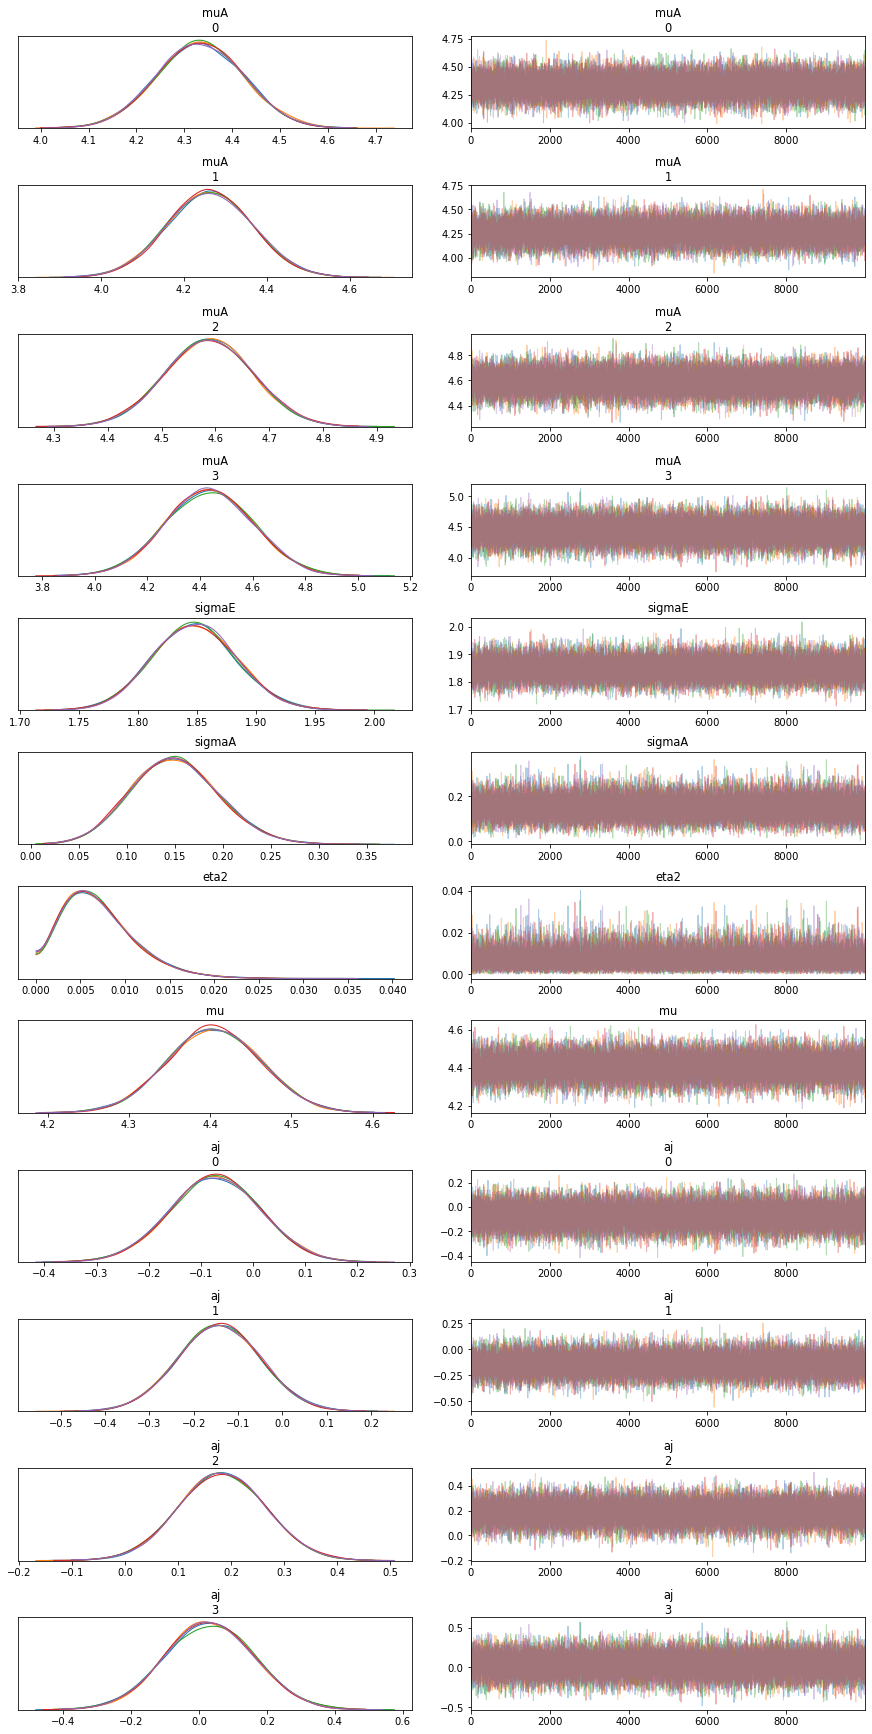

In [34]:
arviz.plot_trace(fit)

In [35]:
type(fit)

stanfit4anon_model_94f0b8e4efc8a07603e3c167ad5a2add_2382378923947034838.StanFit4Model

In [36]:
fit

Inference for Stan model: anon_model_94f0b8e4efc8a07603e3c167ad5a2add.
5 chains, each with iter=11000; warmup=1000; thin=1; 
post-warmup draws per chain=10000, total post-warmup draws=50000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
muA[1]   4.33  3.7e-4   0.09   4.16   4.27   4.33   4.39   4.51  58642    1.0
muA[2]   4.26  4.4e-4    0.1   4.06   4.19   4.26   4.33   4.46  53785    1.0
muA[3]   4.59  3.3e-4   0.08   4.43   4.53   4.59   4.64   4.75  58468    1.0
muA[4]   4.44  7.0e-4   0.16   4.12   4.32   4.44   4.55   4.76  54985    1.0
sigmaE   1.85  1.4e-4   0.03   1.78   1.82   1.85   1.87   1.92  58082    1.0
sigmaA   0.15  2.2e-4   0.04   0.07   0.12   0.15   0.18   0.24  39999    1.0
eta2   7.2e-3  2.1e-5 4.1e-3 1.3e-3 4.2e-3 6.5e-3 9.4e-3   0.02  37569    1.0
mu       4.41  2.4e-4   0.06    4.3   4.37    4.4   4.44   4.52  55100    1.0
aj[1]   -0.07  3.6e-4   0.09  -0.24  -0.13  -0.07  -0.01   0.09  57221    1.0
aj[2]   -0.14  3.9e-4   0.09

In [43]:
samples = fit.extract()

In [45]:
samples.keys()

odict_keys(['muA', 'sigmaE', 'sigmaA', 'eta2', 'mu', 'aj', 'lp__'])